In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import warnings
warnings.filterwarnings(action='ignore')

import folium
KC_coord = (47.4081,-121.9949)
Seattle_coord = (47.6062,-122.3321)
import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-notebook')
from yellowbrick.regressor import ResidualsPlot

import statsmodels.api as sm
from statsmodels.api import OLS

from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OrdinalEncoder, OneHotEncoder

In [2]:
# specify index_col=0 to avoid creating an "Unnamed: 0" column.
# specify parse date to avoid object dtype for dates
df = pd.read_csv('./data/kc_house_data_22.csv', parse_dates=['date']) 
df

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,PUBLIC,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,PUBLIC,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,PUBLIC,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,PUBLIC,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,PUBLIC,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30150,7834800180,2021-11-30,1555000.0,5,2.0,1910,4000,1.5,NO,NO,...,PUBLIC,1600,1130,0,210,1921,0,"4673 Eastern Avenue North, Seattle, Washington...",47.664740,-122.32940
30151,194000695,2021-06-16,1313000.0,3,2.0,2020,5800,2.0,NO,NO,...,PUBLIC,2020,0,0,520,2011,0,"4131 44th Avenue Southwest, Seattle, Washingto...",47.565610,-122.38851
30152,7960100080,2022-05-27,800000.0,3,2.0,1620,3600,1.0,NO,NO,...,PUBLIC,940,920,240,110,1995,0,"910 Martin Luther King Jr Way, Seattle, Washin...",47.610395,-122.29585
30153,2781280080,2022-02-24,775000.0,3,2.5,2570,2889,2.0,NO,NO,...,PUBLIC,1830,740,480,100,2006,0,"17127 114th Avenue Southeast, Renton, Washingt...",47.449490,-122.18908


In [3]:
len(df)

30155

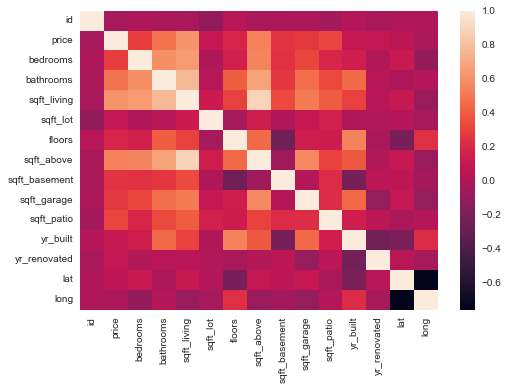

In [4]:
sns.heatmap(df.corr());

In [5]:
zipcode = []

for zips in df['address']:
    zipcode.append(int(zips[-20:-15]))
    
df['zipcode'] = zipcode
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long,zipcode
0,7399300360,2022-05-24,675000.0,4,1.0,1180,7140,1.0,NO,NO,...,1180,0,0,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055
1,8910500230,2021-12-13,920000.0,5,2.5,2770,6703,1.0,NO,NO,...,1570,1570,0,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,98133
2,1180000275,2021-09-29,311000.0,6,2.0,2880,6156,1.0,NO,NO,...,1580,1580,0,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,98178
3,1604601802,2021-12-14,775000.0,3,3.0,2160,1400,2.0,NO,NO,...,1090,1070,200,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,98118
4,8562780790,2021-08-24,592500.0,2,2.0,1120,758,2.0,NO,NO,...,1120,550,550,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,98027


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 26 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             30155 non-null  int64         
 1   date           30155 non-null  datetime64[ns]
 2   price          30155 non-null  float64       
 3   bedrooms       30155 non-null  int64         
 4   bathrooms      30155 non-null  float64       
 5   sqft_living    30155 non-null  int64         
 6   sqft_lot       30155 non-null  int64         
 7   floors         30155 non-null  float64       
 8   waterfront     30155 non-null  object        
 9   greenbelt      30155 non-null  object        
 10  nuisance       30155 non-null  object        
 11  view           30155 non-null  object        
 12  condition      30155 non-null  object        
 13  grade          30155 non-null  object        
 14  heat_source    30123 non-null  object        
 15  sewer_system   3014

# Helper Functions

ohe executes 2 transformations, test and train. data for any given input variable: First, we use OneHotEncoder to split up our categorical variables. Second, we run a linear regression on encoded values using .fit(). Then, it takes in a training df ('df'), a test df ('df2') and a column name. Next, it returns the training df and the test df concatenated with newly encoded columns. Lastly, we return a list of these newly encoded column names. 

In [7]:
def ohe(df, df2, column):
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop='first', sparse=False, handle_unknown="ignore")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train, columns=col_labels, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_labels = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, columns=col_labels, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
        
    return df, df2, encoded_train.columns.tolist()

We run a Standard Scaler to scale all the values in the test data and training data so that our models results are in comparable units. Then, we score the scaled data to get the R2 to assess the strength of our model.

In [8]:
def scale_score(x, y, x2, y2):
    scaler = StandardScaler()
    scaler.fit(x)
    X_train_scaled = scaler.transform(x)
    X_test_scaled = scaler.transform(x2)

    lr = LinearRegression()
    lr.fit(X_train_scaled,y_train)

    train_preds = lr.predict(X_train_scaled)
    test_preds = lr.predict(X_test_scaled)
    
    print(f"""training score: {r2_score(y_train, train_preds)}
    test score: {r2_score(y_test, test_preds)}""")
    
    return X_train_scaled, X_test_scaled, train_preds, test_preds

Uses price and predictions to calculate Mean Absolute Error (MAE), Mean Squared Error (MSE) and Root Mean Squared Error (RSME) for the training and testing data sets. We will compare these values to evaluate model performance.

In [9]:
def get_train_test_metrics(y_train, train_preds,
               y_test, test_preds):
    """
    Prints different training and testing metrics, namely R2, MAE, MSE, RMSE
    """
    print("\nTraining Metrics:")
    print(f"R2: {r2_score(y_train, train_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")
    
    print("\nTesting Metrics:")
    print(f"R2: {r2_score(y_test, test_preds):.3f}")
    print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
    print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
    print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

# Outliers

### Bedrooms

In [10]:
bedrooms_count = print(df['bedrooms'].value_counts())

3     12754
4      9597
2      3936
5      2798
6       498
1       391
7        80
0        44
8        38
9        14
10        3
11        1
13        1
Name: bedrooms, dtype: int64


In [11]:
#drop the 33 bedroom outlier
df = df[df['bedrooms'] != 0]
df = df[df['bedrooms'] != 7]
df = df[df['bedrooms'] != 8]
df = df[df['bedrooms'] != 9]
df = df[df['bedrooms'] != 10]
df = df[df['bedrooms'] != 11]
df = df[df['bedrooms'] != 33]

In [12]:
df['bedrooms_bin']=pd.cut(df['bedrooms'], bins=[0,1,2,3,4,5,6], labels=['1_bed','2_bed','3_bed','4_bed','5_bed','6_bed'])

### Price

In [13]:
# calculate 25, 75, iqr, whiskers for 'price'
price_q75, price_q25 = np.percentile(df['price'], [75, 25])
price_iqr = price_q75 - price_q25
price_min = price_q25 - (1.5 * price_iqr)
price_max = price_q75 + (1.5 * price_iqr)

print(f"""price_min: {price_min} 
price_max: {price_max}""")

price_min: -335000.0 
price_max: 2281000.0


In [14]:
df = df[df['price'] >= price_min]
df = df[df['price'] <= price_max]

### Sqft Lot

In [15]:
# calculate 25, 75, iqr, whiskers for 'sqft_lot'
sqft_lot_q25, sqft_lot_q75 = np.percentile(df['sqft_lot'], [25, 75])
sqft_lot_iqr = sqft_lot_q75 - sqft_lot_q25
sqft_lot_min = sqft_lot_q25 - (1.5 * sqft_lot_iqr)
sqft_lot_max = sqft_lot_q75 + (1.5 * sqft_lot_iqr)


print(f"""sqft_lot_min: {sqft_lot_min} 
sqft_lot_max: {sqft_lot_max}""")

sqft_lot_min: -3347.5 
sqft_lot_max: 18232.5


In [16]:
# set df to include everything within the whiskers except the outliers
df = df[df['sqft_lot'] >= sqft_lot_min]
df = df[df['sqft_lot'] <= sqft_lot_max]

### Condition

In [17]:
floor_count = print(df['condition'].value_counts())

Average      15493
Good          6545
Very Good     2660
Fair           156
Poor            41
Name: condition, dtype: int64


In [18]:
df = df[df['condition'] != 'Poor']

### Floors

In [19]:
floor_count = print(df['floors'].value_counts())

1.0    11828
2.0     9717
1.5     2035
3.0     1110
2.5      120
4.0       29
3.5       15
Name: floors, dtype: int64


In [20]:
df = df[df['floors'] != 4.0]
#df = df[df['floors'] != 2.5]
#df = df[df['floors'] != 3.5]

### Grade

In [21]:
grade_count = print(df['grade'].value_counts())

7 Average        10604
8 Good            8135
9 Better          2685
6 Low Average     2533
10 Very Good       495
5 Fair             286
11 Excellent        54
4 Low               27
3 Poor               3
12 Luxury            3
Name: grade, dtype: int64


In [22]:
df = df[df['grade'] != '3 Poor']
df = df[df['grade'] != '4 Low']
df = df[df['grade'] != '11 Excellent']
df = df[df['grade'] != '12 Luxury']

# Train-Test Split

In [23]:
y = df['price']
X = df.drop('price', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.25)

# Categorical Variables

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24738 entries, 0 to 30154
Data columns (total 27 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   id             24738 non-null  int64         
 1   date           24738 non-null  datetime64[ns]
 2   price          24738 non-null  float64       
 3   bedrooms       24738 non-null  int64         
 4   bathrooms      24738 non-null  float64       
 5   sqft_living    24738 non-null  int64         
 6   sqft_lot       24738 non-null  int64         
 7   floors         24738 non-null  float64       
 8   waterfront     24738 non-null  object        
 9   greenbelt      24738 non-null  object        
 10  nuisance       24738 non-null  object        
 11  view           24738 non-null  object        
 12  condition      24738 non-null  object        
 13  grade          24738 non-null  object        
 14  heat_source    24727 non-null  object        
 15  sewer_system   2473

In [25]:
df.isna().sum()

id                0
date              0
price             0
bedrooms          0
bathrooms         0
sqft_living       0
sqft_lot          0
floors            0
waterfront        0
greenbelt         0
nuisance          0
view              0
condition         0
grade             0
heat_source      11
sewer_system      8
sqft_above        0
sqft_basement     0
sqft_garage       0
sqft_patio        0
yr_built          0
yr_renovated      0
address           0
lat               0
long              0
zipcode           0
bedrooms_bin      0
dtype: int64

In [26]:
df.dropna(inplace=True)

In [27]:
df.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
greenbelt        0
nuisance         0
view             0
condition        0
grade            0
heat_source      0
sewer_system     0
sqft_above       0
sqft_basement    0
sqft_garage      0
sqft_patio       0
yr_built         0
yr_renovated     0
address          0
lat              0
long             0
zipcode          0
bedrooms_bin     0
dtype: int64

In [28]:
#drop the 33 bedroom outlier 
df.drop(['id', 'date', 'heat_source', 'nuisance', 'greenbelt', 'sewer_system', 'sqft_garage', 'sqft_basement'], axis=1, inplace=True)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_patio,yr_built,yr_renovated,address,lat,long,zipcode,bedrooms_bin
0,675000.0,4,1.0,1180,7140,1.0,NO,NONE,Good,7 Average,1180,40,1969,0,"2102 Southeast 21st Court, Renton, Washington ...",47.461975,-122.19052,98055,4_bed
1,920000.0,5,2.5,2770,6703,1.0,NO,AVERAGE,Average,7 Average,1570,240,1950,0,"11231 Greenwood Avenue North, Seattle, Washing...",47.711525,-122.35591,98133,5_bed
2,311000.0,6,2.0,2880,6156,1.0,NO,AVERAGE,Average,7 Average,1580,0,1956,0,"8504 South 113th Street, Seattle, Washington 9...",47.502045,-122.22520,98178,6_bed
3,775000.0,3,3.0,2160,1400,2.0,NO,AVERAGE,Average,9 Better,1090,270,2010,0,"4079 Letitia Avenue South, Seattle, Washington...",47.566110,-122.29020,98118,3_bed
4,592500.0,2,2.0,1120,758,2.0,NO,NONE,Average,7 Average,1120,30,2012,0,"2193 Northwest Talus Drive, Issaquah, Washingt...",47.532470,-122.07188,98027,2_bed


### Bedroom Bins

In [29]:
X_train, X_test, encoded_bedrooms_bins = ohe(X_train, X_test, ['bedrooms_bin'])

In [30]:
X_train.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,nuisance,...,address,lat,long,zipcode,bedrooms_bin,bedrooms_bin_x0_2_bed,bedrooms_bin_x0_3_bed,bedrooms_bin_x0_4_bed,bedrooms_bin_x0_5_bed,bedrooms_bin_x0_6_bed
5083,6404600231,2022-02-06,4,2.5,2320,7746,2.0,NO,NO,NO,...,"13445 22nd Avenue South, SeaTac, Washington 98...",47.481915,-122.30531,98168,4_bed,0.0,0.0,1.0,0.0,0.0
5521,1708400810,2021-10-07,2,1.0,980,5012,1.0,NO,NO,NO,...,"5212 21st Avenue South, Seattle, Washington 98...",47.555505,-122.30587,98108,2_bed,1.0,0.0,0.0,0.0,0.0
28442,6154900050,2021-11-18,2,2.0,1620,6030,1.0,NO,NO,NO,...,"1118 Northwest 103rd Street, Seattle, Washingt...",47.703560,-122.37088,98177,2_bed,1.0,0.0,0.0,0.0,0.0
1573,3679401230,2022-04-20,4,2.0,1750,6221,1.0,NO,NO,YES,...,"4526 15th Avenue South, Seattle, Washington 98...",47.562640,-122.31320,98108,4_bed,0.0,0.0,1.0,0.0,0.0
21587,2891101020,2021-11-19,3,1.0,1340,7368,1.0,NO,NO,NO,...,"1613 19th Drive Northeast, Auburn, Washington ...",47.324085,-122.20792,98002,3_bed,0.0,1.0,0.0,0.0,0.0


### Condition

In [31]:
condition_count = df['condition'].value_counts()
condition_count

Average      15378
Good          6532
Very Good     2657
Fair           152
Name: condition, dtype: int64

In [32]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [33]:
X_train['condition'] = X_train['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

In [34]:
X_test['condition'] = X_test['condition'].map({'Very Good': 5, 'Good': 4, 'Average': 3, 'Fair': 2, 'Poor': 1})

### Floors

In [35]:
floor_count = print(df['floors'].value_counts())

1.0    11794
2.0     9654
1.5     2028
3.0     1108
2.5      120
3.5       15
Name: floors, dtype: int64


In [36]:
X_train, X_test, encoded_floors = ohe(X_train, X_test, ['floors'])

In [37]:
X_train['floors'] = X_train['floors'].map({1.0: 1, 1.5: 1, 2.0: 2, 2.5: 2, 3.0: 3, 3.5: 3, 4.0: 4})

In [38]:
X_test['floors'] = X_test['floors'].map({1.0: 1, 1.5: 1, 2.0: 2, 2.5: 2, 3.0: 3, 3.5: 3, 4.0: 4})

### Grade

In [39]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

### View

In [40]:
X_train['view'].isna().sum()

0

In [41]:
view_count = df['view'].value_counts()
view_count

NONE         22552
AVERAGE       1335
GOOD           492
EXCELLENT      179
FAIR           161
Name: view, dtype: int64

In [42]:
X_train['view'].fillna('NONE', inplace=True)
X_test['view'].fillna('NONE', inplace=True)

In [43]:
X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [44]:
X_train['view'] = X_train['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

In [45]:
X_test['view'] = X_test['view'].map({'EXCELLENT': 5, 'GOOD': 4, 'AVERAGE': 3, 'FAIR': 2, 'NONE': 1})

### Waterfront

In [46]:
X_train['waterfront'].fillna('NO', inplace=True)
X_test['waterfront'].fillna('NO', inplace=True)

In [47]:
waterfront_train = X_train[['waterfront']]

encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_train)
encoder_waterfront.categories_[0]

waterfront_encoded_train = encoder_waterfront.transform(waterfront_train)
waterfront_encoded_train = waterfront_encoded_train.flatten()

X_train['waterfront'] = waterfront_encoded_train

In [48]:
waterfront_test = X_test[['waterfront']]

encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_test)
encoder_waterfront.categories_[0]

waterfront_encoded_test = encoder_waterfront.transform(waterfront_test)
waterfront_encoded_test = waterfront_encoded_train.flatten()

X_train['waterfront'] = waterfront_encoded_test

### Zipcode

In [49]:
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

# Models

In [50]:
dummy = DummyRegressor()
dummy.fit(X_train, y_train)
basemodel_dummy_score = dummy.score(X_train, y_train)
test_dummy_score = dummy.score(X_test, y_test)

print(f"""basemodel_dummy_score: {basemodel_dummy_score}

test_dummy_score: {test_dummy_score}""")

basemodel_dummy_score: 0.0

test_dummy_score: -0.000414179069886611


In [51]:
df.corr()['price'].abs().sort_values(ascending=False)

price           1.000000
sqft_living     0.552073
sqft_above      0.447778
bathrooms       0.420383
bedrooms        0.317601
sqft_patio      0.226753
floors          0.180248
lat             0.082080
yr_renovated    0.065214
sqft_lot        0.054432
yr_built        0.047294
long            0.027572
zipcode         0.024684
Name: price, dtype: float64

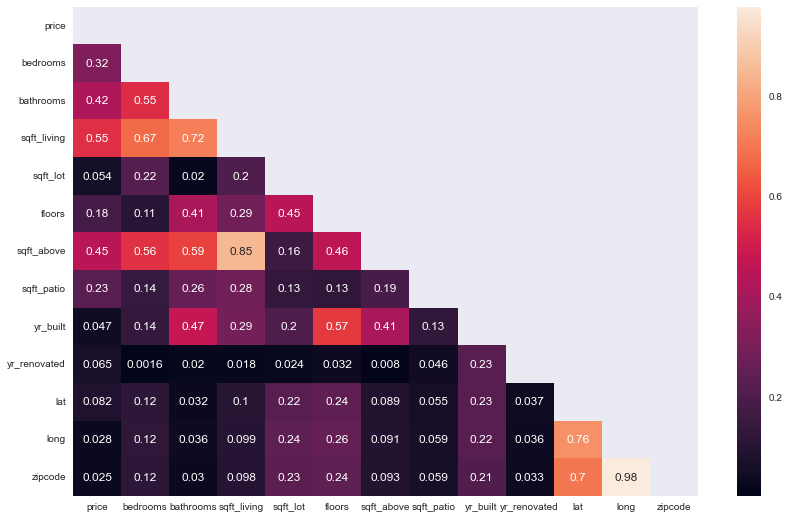

In [52]:
with sns.axes_style("darkgrid"):
    fig, ax = plt.subplots(figsize=(14, 9))
    
    mask = np.triu(np.ones_like(df.corr(), dtype=bool))
    ax = sns.heatmap(abs(df.corr()),mask=mask,annot=True)
    fig.savefig('images/Corelation_Heatmap_22',bbox_inches="tight")

### Model 1

In [53]:
cols = ['sqft_living']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [54]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3049085845081817
    test score: 0.30400212450688635


In [55]:
y_sqft_liv = df['price']
X_sqft_liv = df[['sqft_living']]

model = sm.OLS(y_sqft_liv, sm.add_constant(X_sqft_liv)).fit()
model_summary = model.summary()
model_summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.305
Model:                            OLS   Adj. R-squared:                  0.305
Method:                 Least Squares   F-statistic:                 1.084e+04
Date:                Mon, 01 Aug 2022   Prob (F-statistic):               0.00
Time:                        19:33:21   Log-Likelihood:            -3.5085e+05
No. Observations:               24719   AIC:                         7.017e+05
Df Residuals:                   24717   BIC:                         7.017e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        3.186e+05   6222.930     51.190      0.000    3.06e+05    3.31e+05
sqft_living   313.4653      3.011    104.096      0.000     307.563     319.368
==============================================================================
Omnibus:                     1394.887   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1748.518
Skew:                           0.561   Prob(JB):                         0.00
Kurtosis:                       3.662   Cond. No.                     5.72e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.72e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Model 2

In [56]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15'] + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [57]:
X_train_scaled, X_test_scaled, train_preds, test_preds=scale_score(x, y, x2, y2)

training score: 0.6814252565014915
    test score: 0.6732723197161194


In [58]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.681
Mean Absolute Error: 168228.781
Mean Squared Error: 57316854564.579
Root Mean Squared Error: 239409.387

Testing Metrics:
R2: 0.673
Mean Absolute Error: 172119.903
Mean Squared Error: 58067584962.570
Root Mean Squared Error: 240972.166


### Model 2b

In [59]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'zipcode']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [60]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3070623600172696
    test score: 0.30486190592750106


In [61]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.307
Mean Absolute Error: 274874.891
Mean Squared Error: 124670918658.052
Root Mean Squared Error: 353087.693

Testing Metrics:
R2: 0.305
Mean Absolute Error: 274839.442
Mean Squared Error: 123543221998.217
Root Mean Squared Error: 351487.158


### Model 3

In [62]:
cols = ['bedrooms', 'sqft_living', 'sqft_living15']

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [63]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.3094590627465559
    test score: 0.3116381467324051


In [64]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.309
Mean Absolute Error: 274028.334
Mean Squared Error: 124239712278.474
Root Mean Squared Error: 352476.541

Testing Metrics:
R2: 0.312
Mean Absolute Error: 272387.923
Mean Squared Error: 122338916509.549
Root Mean Squared Error: 349769.805


### Model 3b

In [65]:
cols = ['sqft_living', 'sqft_living15'] + encoded_bedrooms_bins + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [66]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6829205518102813
    test score: 0.6751667741698847


In [67]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.683
Mean Absolute Error: 167911.467
Mean Squared Error: 57047826258.054
Root Mean Squared Error: 238846.868

Testing Metrics:
R2: 0.675
Mean Absolute Error: 171817.579
Mean Squared Error: 57730893578.308
Root Mean Squared Error: 240272.540


### Model 4

In [68]:
cols = ['bedrooms', 'sqft_living'] + encoded_condition + encoded_zipcode 

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [69]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6878669967544242
    test score: 0.6785025829398846


In [70]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.688
Mean Absolute Error: 165577.142
Mean Squared Error: 56157879169.463
Root Mean Squared Error: 236976.537

Testing Metrics:
R2: 0.679
Mean Absolute Error: 170059.878
Mean Squared Error: 57138037904.119
Root Mean Squared Error: 239035.641


### Model 4b

In [71]:
cols = ['sqft_living'] + encoded_bedrooms_bins + encoded_condition + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [72]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6891754540007229
    test score: 0.6802072780295368


In [73]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.689
Mean Absolute Error: 165327.572
Mean Squared Error: 55922466114.220
Root Mean Squared Error: 236479.314

Testing Metrics:
R2: 0.680
Mean Absolute Error: 169806.002
Mean Squared Error: 56835071449.401
Root Mean Squared Error: 238401.073


### Model 5

In [74]:
cols = ['bathrooms', 'bedrooms', 'condition', 'sqft_living', 'view'] + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [75]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6963134082029376
    test score: 0.6869026898414115


In [76]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.696
Mean Absolute Error: 163172.795
Mean Squared Error: 54638230338.326
Root Mean Squared Error: 233748.220

Testing Metrics:
R2: 0.687
Mean Absolute Error: 167432.117
Mean Squared Error: 55645131270.756
Root Mean Squared Error: 235892.203


### Model 5b

In [77]:
cols = ['bathrooms', 'sqft_living'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [78]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6989500678285613
    test score: 0.6899127643538581


In [79]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.699
Mean Absolute Error: 162739.991
Mean Squared Error: 54163851752.508
Root Mean Squared Error: 232731.287

Testing Metrics:
R2: 0.690
Mean Absolute Error: 166946.121
Mean Squared Error: 55110166625.754
Root Mean Squared Error: 234755.547


### Model 6

In [80]:
cols = ['bathrooms', 'bedrooms', 'sqft_living', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [81]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6976801208263421
    test score: 0.6882297593773921


In [82]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.698
Mean Absolute Error: 162936.988
Mean Squared Error: 54392336179.213
Root Mean Squared Error: 233221.646

Testing Metrics:
R2: 0.688
Mean Absolute Error: 167176.571
Mean Squared Error: 55409278211.214
Root Mean Squared Error: 235391.755


### Model 6b

In [83]:
cols = ['bathrooms', 'sqft_living', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [84]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6989517615281766
    test score: 0.6899027601660042


In [85]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.699
Mean Absolute Error: 162749.536
Mean Squared Error: 54163547027.992
Root Mean Squared Error: 232730.632

Testing Metrics:
R2: 0.690
Mean Absolute Error: 166953.530
Mean Squared Error: 55111944617.223
Root Mean Squared Error: 234759.333


### Model 7

In [86]:
cols = ['bathrooms', 'bedrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [87]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6976801208263421
    test score: 0.6882297593773921


In [88]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.698
Mean Absolute Error: 162936.988
Mean Squared Error: 54392336179.213
Root Mean Squared Error: 233221.646

Testing Metrics:
R2: 0.688
Mean Absolute Error: 167176.571
Mean Squared Error: 55409278211.214
Root Mean Squared Error: 235391.755


### Model 7b

In [89]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [90]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6989517615281766
    test score: 0.6899027601660042


In [91]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.699
Mean Absolute Error: 162749.536
Mean Squared Error: 54163547027.992
Root Mean Squared Error: 232730.632

Testing Metrics:
R2: 0.690
Mean Absolute Error: 166953.530
Mean Squared Error: 55111944617.223
Root Mean Squared Error: 234759.333


### Model 8

In [92]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [93]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6895043788377538
    test score: 0.6807824112906611


In [94]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.690
Mean Absolute Error: 165244.641
Mean Squared Error: 55863287106.996
Root Mean Squared Error: 236354.156

Testing Metrics:
R2: 0.681
Mean Absolute Error: 169618.273
Mean Squared Error: 56732856052.542
Root Mean Squared Error: 238186.599


### Model 9

In [95]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [96]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7161937276095207
    test score: 0.7143180225533511


In [97]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.716
Mean Absolute Error: 157911.217
Mean Squared Error: 51061432744.107
Root Mean Squared Error: 225967.769

Testing Metrics:
R2: 0.714
Mean Absolute Error: 160774.943
Mean Squared Error: 50772748985.470
Root Mean Squared Error: 225328.092


### Model 10

In [98]:
cols = ['sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [99]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.698733033076854
    test score: 0.689457895758157


In [100]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.699
Mean Absolute Error: 162799.534
Mean Squared Error: 54202899886.590
Root Mean Squared Error: 232815.162

Testing Metrics:
R2: 0.689
Mean Absolute Error: 167085.115
Mean Squared Error: 55191008018.821
Root Mean Squared Error: 234927.666


### Model 11

In [101]:
cols = ['sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_floors + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [102]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7003330652824069
    test score: 0.6897238504876955


In [103]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.700
Mean Absolute Error: 162465.828
Mean Squared Error: 53915027683.611
Root Mean Squared Error: 232196.097

Testing Metrics:
R2: 0.690
Mean Absolute Error: 167126.933
Mean Squared Error: 55143741289.415
Root Mean Squared Error: 234827.045


### Model 11b

In [104]:
cols = ['floors', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [105]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6989049004183276
    test score: 0.6897882343435718


In [106]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.699
Mean Absolute Error: 162848.660
Mean Squared Error: 54171978115.116
Root Mean Squared Error: 232748.745

Testing Metrics:
R2: 0.690
Mean Absolute Error: 167146.868
Mean Squared Error: 55132298686.761
Root Mean Squared Error: 234802.680


### Model 12

In [107]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_floors + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [108]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7173771199241397
    test score: 0.7147235914658157


In [109]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.717
Mean Absolute Error: 157544.977
Mean Squared Error: 50848520934.323
Root Mean Squared Error: 225496.166

Testing Metrics:
R2: 0.715
Mean Absolute Error: 160423.041
Mean Squared Error: 50700669364.722
Root Mean Squared Error: 225168.091


### Model 12b

In [110]:
cols = ['bathrooms', 'floors', 'sqft_living', 'sqft_living15', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [111]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7162223994437298
    test score: 0.7143703988306243


In [112]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.716
Mean Absolute Error: 157882.063
Mean Squared Error: 51056274207.892
Root Mean Squared Error: 225956.355

Testing Metrics:
R2: 0.714
Mean Absolute Error: 160713.089
Mean Squared Error: 50763440426.342
Root Mean Squared Error: 225307.435


### Model 13

In [113]:
cols = ['bathrooms', 'floors', 'sqft_living', 'sqft_living15', 'sqft_patio', 'yr_built'] + encoded_bedrooms_bins + encoded_condition + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [114]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7164341381921788
    test score: 0.7145472235853253


In [115]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.716
Mean Absolute Error: 157782.518
Mean Squared Error: 51018178912.210
Root Mean Squared Error: 225872.041

Testing Metrics:
R2: 0.715
Mean Absolute Error: 160556.701
Mean Squared Error: 50732014296.612
Root Mean Squared Error: 225237.684


### Model 14

In [116]:
cols = ['bathrooms', 'floors', 'sqft_living', 'sqft_living15', 'sqft_patio', 'yr_built', 'yr_renovated'] + encoded_bedrooms_bins + encoded_condition + encoded_grade + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [117]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7169560064719889
    test score: 0.7155881918540654


In [118]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.717
Mean Absolute Error: 157559.018
Mean Squared Error: 50924286195.018
Root Mean Squared Error: 225664.100

Testing Metrics:
R2: 0.716
Mean Absolute Error: 160188.565
Mean Squared Error: 50547008504.217
Root Mean Squared Error: 224826.619


### Model 15

In [119]:
cols = ['bathrooms', 'sqft_living', 'sqft_living15', 'yr_built', 'yr_renovated'] + encoded_bedrooms_bins + encoded_condition + encoded_floors + encoded_view + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [120]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.7010991936334565
    test score: 0.6913406510648726


In [121]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.701
Mean Absolute Error: 162206.101
Mean Squared Error: 53777188547.989
Root Mean Squared Error: 231899.091

Testing Metrics:
R2: 0.691
Mean Absolute Error: 166539.611
Mean Squared Error: 54856395862.173
Root Mean Squared Error: 234214.423


### Model 16

In [122]:
cols = ['sqft_living'] + encoded_zipcode

y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [123]:
X_train_scaled, X_test_scaled, train_preds, test_preds = scale_score(x, y, x2, y2)

training score: 0.6812493344805675
    test score: 0.6728941372488173


In [124]:
get_train_test_metrics(y_train, train_preds, y_test, test_preds)


Training Metrics:
R2: 0.681
Mean Absolute Error: 168235.595
Mean Squared Error: 57348505839.809
Root Mean Squared Error: 239475.481

Testing Metrics:
R2: 0.673
Mean Absolute Error: 172249.670
Mean Squared Error: 58134797335.065
Root Mean Squared Error: 241111.587
